In [1]:
# from rfgap import RFGAP
from rfgap import RFGAP

from sklearn.model_selection import train_test_split
from dataset import dataprep


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read in the data and normalize

In [2]:
# TODO: Test with NumPy and Pandas, ALL METHODS and perhaps combos of each type. Problem with categorical data in Pandas?
# We should probably modify RFGAP to handle categorical data in the form of strings.

In [3]:
seed = 42
test_size = 0.2   # final test split
val_size  = 0.2   # validation fraction of the *remaining* (train+val) pool
prox_method = 'rfgap'
model_type='rf'
force_symmetric = False
non_zero_diagonal = False
oob_score = True
verbose=True
test_size=0.2
n_jobs = -1

data = pd.read_csv('/Users/aumona/Projects/RF-GAP-Python/data/iris.csv')
x, y   = dataprep(data)

n_samples = x.shape[0]
n_features = x.shape[1]



# 1) Split off TEST
x_trainval, x_test, y_trainval, y_test = train_test_split(
    x, y,
    test_size=test_size,
    random_state=seed,
    stratify=y  # good practice for classification
)

# 2) Split TRAIN vs VAL from the remaining pool
#    (val_size is relative to trainval; if you want val to be 20% of the FULL dataset,
#     set val_size = 0.2 / (1 - test_size) )
x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval,
    test_size=val_size,
    random_state=seed,
    stratify=y_trainval
)

print(f"Train samples: {x_train.shape[0]}")
print(f"Val samples:   {x_val.shape[0]}")
print(f"Test samples:  {x_test.shape[0]}")
print(f"Number of features: {x_train.shape[1]}")

Train samples: 96
Val samples:   24
Test samples:  30
Number of features: 4


## Train the RF Model

In [4]:
rf = RFGAP(y = y_train, prox_method = prox_method, matrix_type = 'sparse', oob_score = True, non_zero_diagonal = non_zero_diagonal,
           random_state = seed, model_type=model_type, n_jobs = n_jobs, force_symmetric = force_symmetric, verbose=verbose)

In [5]:
rf.fit(x_train, y_train, X_unlabeled=x_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


,prox_method,'rfgap'
,matrix_type,'sparse'
,non_zero_diagonal,True
,force_symmetric,True


## Generate the Proximity Matrix

In [6]:
# compute/get proximity matrix and visualize with seaborn heatmap
prox = rf.get_proximities()
# prox = rf.prox_extend(np.vstack([x_train, x_val]))

# Visualize it

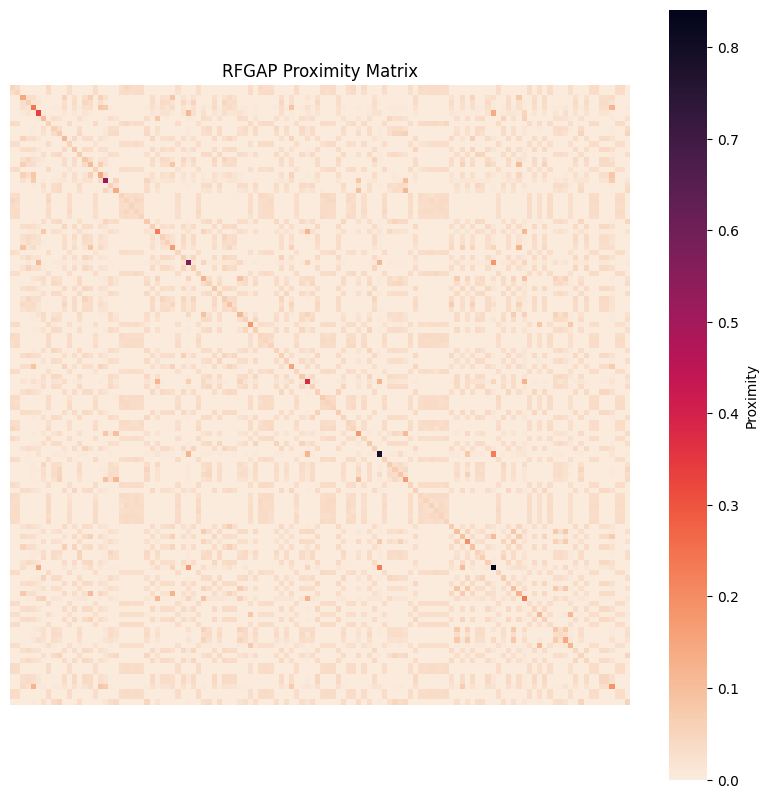

In [7]:
prox_mat = prox.toarray()

# mask diagonal to emphasize off-diagonal proximities
# mask = np.eye(prox_mat.shape[0], dtype=bool)
mask=None

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(prox_mat, ax=ax, cmap='rocket_r', vmin=0, vmax=prox_mat.max(),
            mask=mask,
            xticklabels=False, yticklabels=False, square=True, cbar_kws={'label': 'Proximity'})
ax.set_title(f'{prox_method.upper()} Proximity Matrix')
plt.show()

## Check extended proximity computation

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


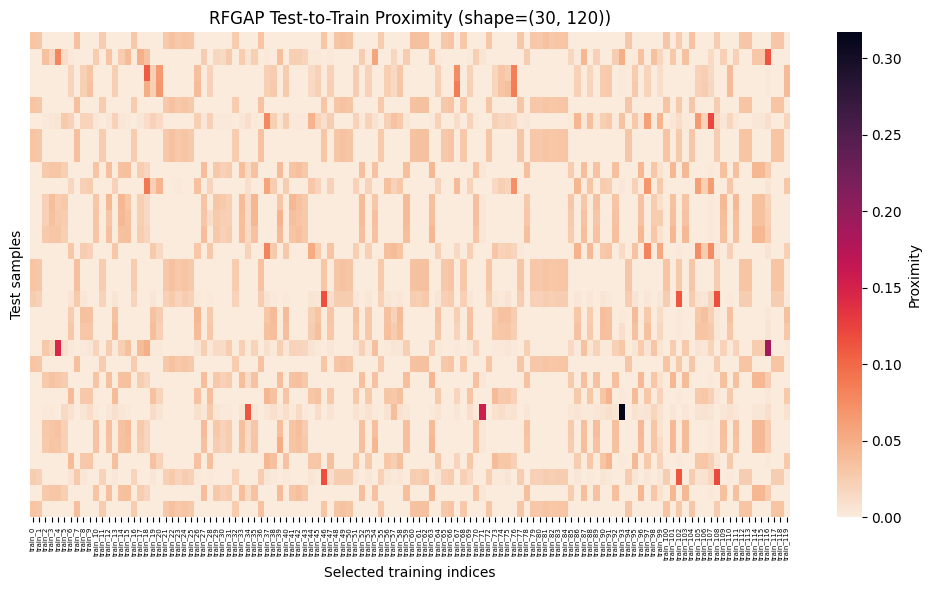

In [8]:
# selected_train_indices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
test_prox = rf.prox_extend(x_test).toarray()
selected_train_indices = np.arange(test_prox.shape[1])
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(test_prox, ax=ax, cmap='rocket_r', vmin=0, vmax=test_prox.max(),
            xticklabels=[f'train_{i}' for i in selected_train_indices],
            yticklabels=False, cbar_kws={'label': 'Proximity'})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=5) # 'ha' aligns text nicely with rotation
ax.set_xlabel('Selected training indices')
ax.set_ylabel('Test samples')
ax.set_title(f'{prox_method.upper()} Test-to-Train Proximity (shape={test_prox.shape})')
plt.tight_layout()
plt.show()